# Lossy materials using conductivity
Currently, FDTDX supports using lossy materials through the setting of a real- and scalar-valued conductivity $\sigma$,
through the parameter named `electric_conductivity` in `Material`.
So far, it implements the vector form of Ohm's law, $\mathbf{J}_f = \sigma \mathbf{E}$, where $\mathbf{J}_f$ is the free current density.
This is then applied to the macroscopic Ampère-Maxwell equation,

$$
\mathbf{\nabla} \times \mathbf{H} = \mathbf{J}_f + \frac{\partial \mathbf{D}}{\partial t},
\qquad\text{(1)}
$$

where 

$$
{\begin{aligned}\mathbf {D} (\mathbf{r},t) &= \varepsilon_{0}\mathbf{E} (\mathbf{r} ,t) + \mathbf{P}(\mathbf{r} ,t), \\
\mathbf{H} (\mathbf{r},t) &= {\frac{1}{\mu_{0}}}\mathbf{B}(\mathbf{r},t) - \mathbf{M}(\mathbf{r}, t). \end{aligned}}
\qquad\text{(2)}
$$

Conductivity can be used either to model losses due to free currents (like those
induced by an electric field on a non-ideal metal), or, if the right assumptions
hold, due to bound currents which have polarization lag (dipoles oscillating do
not instantly move once an electric field impinges on them) in a lossy
dielectric, making it equivalent to specifying an *imaginary* component,
$\varepsilon''$, of a complex-valued dielectric permittivity
$\varepsilon = \varepsilon' - \mathrm{i}\varepsilon''$.
Below, we shall derive the reasoning behind this equivalence:

Assume (FDTDX assumes this too) that we are using linear materials ($\mathbf{P}
= \chi \mathbf{E}$, $\mathbf{M} = \chi_m \mathbf{H}$, which implies that we can
write $\mathbf{D} = \varepsilon \mathbf{E}$ and $\mathbf{H} = \frac{1}{\mu}
\mathbf{B}$), as well as time-invariant ones ($\mu$ and $\varepsilon$ constant
with time; we can take these two out of $\frac{\partial}{\partial t}$). Since
this means that the Maxwell equations are also linear, contain no explicit time
dependence (aside from partial derivatives) then the electric and magnetic
fields can each be expressed as a product of factors, each only depending on
space or time. Using these assumptions, we can furthermore express the
time-dependent factor of the electric and magnetic fields as an oscillatory
function, which, as convenience, we'll use a complex exponential;

$$
\mathbf{F}(\mathbf{r}, t) = \mathrm{Re}\{\mathbf{\tilde{F}}(\mathbf{r})\mathrm{e}^{\mathrm{i}\omega t}\},
\qquad\text{(3)}
$$

where $\mathbf{F}$ can be any of $\mathbf{E}, \mathbf{D}, \mathbf{B},
\mathbf{H}$, and $\omega = 2 \pi f$. Then we can apply the partial derivative
with respect to $t$ in Ampère-Maxwell which results in the same exact field, but
with a factor of $\mathrm{i}\omega$. If we replace $\mathbf{J}_f$ for $\sigma
\mathbf{E}$ following Ohm's law, and if we then use this complex (or phasor)
form, eliminate $\mathrm{Re}\{\}$ and $\mathrm{e}^{\mathrm{i}\omega t}$ from
both sides of the equation, as they are not affected by derivatives with respect
to space, we finally have

$$
\mathbf{\nabla} \times \mathbf{\tilde{H}} = \sigma\mathbf{\tilde{E}} + \varepsilon \mathrm{i} \omega \mathbf{\tilde{E}}.
\qquad\text{(4)}
$$

Note that there is a term multiplied by a real factor, and another multiplied by
an imaginary one. If we now consider Ampère-Maxwell as before, but with complex
permittivity and no current density, we have that

$$
\mathbf{\nabla} \times \mathbf{\tilde{H}}
= \varepsilon \mathrm{i} \omega \mathbf{\tilde{E}}
= (\varepsilon' - \mathrm{i}\varepsilon'')\mathrm{i}\omega \mathbf{\tilde{E}}
\rightarrow
\mathbf{\nabla} \times \mathbf{\tilde{H}}
= \varepsilon''\omega\mathbf{\tilde{E}} + \varepsilon'\mathrm{i}\omega \mathbf{\tilde{E}}.
\qquad\text{(5)}
$$

After this manipulation, you'll notice that we also have a real and an imaginary
factor, and we can easily draw the correspondence $\sigma_{\mathrm{eff}} =
\varepsilon'' \omega = \varepsilon_0 \varepsilon_{r}'' \omega$ from the real
factor. Therefore, if we wish to model a material with a complex permittivity by
using conductivity, one just needs $\varepsilon''(\omega)$, as well as $\omega$
itself, to calculate $\sigma_{\mathrm{eff}}$, which is then input into
`electric_conductivity`.

Now, we should be careful with this. One must constantly adjust
$\sigma_{\mathrm{eff}}$ as frequency is changed in order to obtain the correct
$\varepsilon''$. Otherwise, if $\sigma_{\mathrm{eff}}$ is left constant as
frequency is changed, the dependence on frequency would be quite different from
what is observed in reality; $\varepsilon''(\omega)$ presents poles in many
materials due to its nature, that is, it has peaks. By contrast, if this
effective conductivity is not changed with frequency, the imaginary permittivity
that FDTDX operates with varies as $1/\omega$, which has nothing to do with the
physical value.

Another important consideration to take into account is that, currently,
dispersion is not implemented in FDTDX. If a broadband source is used,
then the simulation will be potentially inaccurate, as the permittivity, and
the conductivity, will both be the same for every frequency of the incident
radiation. So, if you want an accurate simulation, you can only
use one monochromatic wave, for now. There's many situations where conductivity
doesn't vary with frequency much (highly conductive metals); but a
frequency-dependent conductivity is necessary if imaginary permittivity is to be
simulated, as the latter does vary significantly in many materials.

This is only just for describing dielectric media with no actual conductivity to
speak of. If we consider both conductivity and complex permittivity, we have
that

$$
\mathbf{\nabla} \times \mathbf{\tilde{H}} = (\sigma + \varepsilon''\omega)\mathbf{\tilde{E}} + \varepsilon' \mathrm{i} \omega \mathbf{\tilde{E}},
\qquad\text{(6)}
$$

then, in FDTDX, we'd have to set `electric_conductivity` to be
$\sigma_{\mathrm{eff}} = \sigma + \varepsilon''\omega$. Again, we need to know
the value of $\sigma(\omega)$, $\varepsilon''(\omega)$ and $\omega$.

In this notebook, we will demonstrate how to use such a lossy material,
propagate a plane wave through its interior, and we will compare the power flux
obtained by FDTDX with an analytical result. We begin by importing the relevant
packages,

In [1]:
import os
import time

import jax
import jax.numpy as jnp
import pytreeclass as tc
from loguru import logger
import matplotlib.pyplot as plt

import fdtdx
# We force the use of a single GPU
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [2]:
%matplotlib inline

Setting wave properties. We choose a wave with a vacuum wavelength of 7.4 mm,
approximately corresponding to a frequency of 40.512 GHz. Wavelength changes
with $\mu$ and $\varepsilon$ leaving frequency intact, so be careful when
defining properties of the incident radiation.

In [3]:
# Field/wave properties
wavelength = 7.4e-3
period = fdtdx.constants.wavelength_to_period(wavelength)
frequency = 1 / period
field_initial_amp = 1.0
# Material properties
# Relative permittivity
eps_r = 2.0
# Relative permeability
mu_r = 1.0
# Conductivity
sigma = 5.0

Start the logger, set random seed and simulation configuration with duration in
time, `time`, length of each cube-shaped cell `resolution`, and the Courant
factor `courant_factor`,

In [4]:
exp_logger = fdtdx.Logger(
    experiment_name="simulate_lossy_material",
)
key = jax.random.PRNGKey(seed=42)
key, subkey = jax.random.split(key)

cell_size = 1e-4

config = fdtdx.SimulationConfig(
    time=100e-11,
    resolution=cell_size,
    courant_factor=0.99,
)

Output()

24.07.2025 09:37:52.595 | 
/home/mahlau/nobackup/fdtdx-notebooks/.venv/lib/python3.12/site-packages/fdtdx/utils/logger.py:125 - Starting 
experiment simulate_lossy_material in 
/home/mahlau/nobackup/fdtdx-notebooks/outputs/nobackup/2025-07-24/simulate_lossy_material/09-37-52.585848

Logging field and material parameters used in the simulation.

In [ ]:
period_steps = round(period / config.time_step_duration)
all_time_steps = list(range(config.time_steps_total))
logger.info(f"{config.time_steps_total=}")
logger.info(f"{period_steps=}")
logger.info(f"{config.max_travel_distance=}")
logger.info(f"{wavelength=}")
logger.info(f"{eps_r=}")
logger.info(f"{mu_r=}")
logger.info(f"{sigma=}")

24.07.2025 09:37:54.216 | /tmp/ipykernel_3300530/1765015153.py:3 - config.time_steps_total=5245

24.07.2025 09:37:54.217 | /tmp/ipykernel_3300530/1765015153.py:4 - period_steps=129

24.07.2025 09:37:54.218 | /tmp/ipykernel_3300530/1765015153.py:5 - config.max_travel_distance=0.29979245800000004

24.07.2025 09:37:54.219 | /tmp/ipykernel_3300530/1765015153.py:6 - wavelength=0.0074

24.07.2025 09:37:54.219 | /tmp/ipykernel_3300530/1765015153.py:7 - eps_r=2.0

24.07.2025 09:37:54.220 | /tmp/ipykernel_3300530/1765015153.py:8 - mu_r=1.0

Initializing list where position constraints will be stored, as well as
instantiating the object holding information about the simulation volume.
We specify the dimensions in each axis in meters in `partial_real_shape`.
Keep in mind that you should pick a simulation volume size that is at least a
few times bigger than the wavelength. Especially on the direction along which
the wave propagates.

In [ ]:
constraints = []

volume = fdtdx.SimulationVolume(
    partial_real_shape=(12e-3, 12e-3, 32e-3),
)

Setting boundary conditions. We want periodic boundary conditions at the minimum
and maximum values of both X and Y axis, and a perfectly matched layer (PML)
simulating an open boundary on the minimum and maximum value of the Z axis.
It is also necessary to specify a certain thickness of the PML.

In [ ]:
thickness = 20  # In grid units
kappa_start = 1.0 # This must be 1 at the beginning of the PML so that impedance is matched
kappa_end = 1.5
bound_cfg = fdtdx.BoundaryConfig(
    boundary_type_minx="periodic",
    boundary_type_maxx="periodic",
    boundary_type_miny="periodic",
    boundary_type_maxy="periodic",
    boundary_type_minz="pml",
    boundary_type_maxz="pml",
    thickness_grid_minx=thickness,
    thickness_grid_maxx=thickness,
    thickness_grid_miny=thickness,
    thickness_grid_maxy=thickness,
    thickness_grid_minz=thickness,
    thickness_grid_maxz=thickness,
    kappa_start_minx=kappa_start,
    kappa_end_minx=kappa_end,
    kappa_start_maxx=kappa_start,
    kappa_end_maxx=kappa_end,
    kappa_start_miny=kappa_start,
    kappa_end_miny=kappa_end,
    kappa_start_maxy=kappa_start,
    kappa_end_maxy=kappa_end,
    kappa_start_minz=kappa_start,
    kappa_end_minz=kappa_end,
    kappa_start_maxz=kappa_start,
    kappa_end_maxz=kappa_end,
)
_, c_list = fdtdx.boundary_objects_from_config(bound_cfg, volume)
constraints.extend(c_list)

Setting a source for the field. We define an amplitude for the wave in
`amplitude`, and the wavelength is defined through a `WaveCharacter` object
passed to the parameter `wave_character`. We also set the polarization of the
electric field as a tuple holding the components (x, y, z) in
`fixed_E_polarization_vector`, and the propagation direction in `direction`.
From these two, the polarization of the magnetic field strength $\mathbf{H}$ is
determined.

After that, we extend the `constraints` list with the position this source
has in the simulation volume. In `own_positions`, we specify the position of the anchor
of the source, in this case being at its center, and in `other_positions` we
specify the position of the anchor of the volume, this indicating that it is at
the top of the volume, at its maximum value in the z axis
(indicated by a 1 in the last element of the tuple) and at its center in the x and y axis.

In `grid_margins` we specify the distance from the anchor of the volume to the anchor
of the source in grid units. We want to position the source slightly below the
top of the volume. Remember that, at the top and the bottom of the simulation volume,
we have PML boundaries, and these have a certain thickness. We thus want to position
the source outside of the top PML. Hence, in `grid_margins`, we specify
that we are 4 grid units plus the thickness of the PML away from the volume anchor.

In [ ]:
source = fdtdx.UniformPlaneSource(
    amplitude=field_initial_amp,
    partial_grid_shape=(None, None, 1),
    partial_real_shape=(None, None, None),
    fixed_E_polarization_vector=(1, 0, 0),
    # partial_grid_shape=(1, None, None),
    # partial_real_shape=(None, 10e-6, 10e-6),
    # fixed_E_polarization_vector=(0, 1, 0),
    # partial_grid_shape=(None, 1, None),
    # partial_real_shape=(10e-6, None, 10e-6),
    # fixed_E_polarization_vector=(1, 0, 0),
    wave_character=fdtdx.WaveCharacter(wavelength=wavelength),
    direction="-",
)
constraints.extend([
    source.place_relative_to(
        volume,
        axes=(0, 1, 2),
        own_positions=(0, 0, 0),
        other_positions=(0, 0, 1),
        grid_margins=(0, 0, -(bound_cfg.thickness_grid_maxz + 4)),
    ),
])

Here we specify a lossy material occupying 70% of the simulation volume.

In [9]:
lossy_medium = fdtdx.UniformMaterialObject(
    partial_real_shape=(None, None, 0.7 * 32e-3),
    material=fdtdx.Material(
        permittivity=eps_r,
        permeability=mu_r,
        electric_conductivity=sigma,
    ),
    color=fdtdx.colors.CYAN,
    name="Lossy medium",
)
constraints.extend([
    lossy_medium.place_relative_to(
        volume,
        axes=(0, 1, 2),
        own_positions=(0, 0, -1),
        other_positions=(0, 0, -1),
        grid_margins=(0, 0, 0),
    ),
])

We create two detector objects. `PoyntingFluxDetector` measures the power flux per unit area
through its surface. If `reduce_volume` is set to `True`, then the power flux is summed
so that the total power flux through the detector is obtained. We place one detector right after
the lossy medium begins, and the other detector is placed deeper inside the medium.

In [10]:
detector_1 = fdtdx.PoyntingFluxDetector(
    color=fdtdx.colors.LIGHT_GREEN,
    name="Detector 1",
    reduce_volume=True,
    # An XY plane, with a thickness of 1 grid cell in the Z direction
    partial_grid_shape=(None, None, 1),
    direction="-",
    # When does the detector record data?
    switch=fdtdx.OnOffSwitch(fixed_on_time_steps=all_time_steps[:]),
)
constraints.append(
    detector_1.place_relative_to(
        lossy_medium,
        axes=(2,),
        own_positions=(0,),
        other_positions=(1,),
        grid_margins=(-5,),
    )
)

detector_2 = fdtdx.PoyntingFluxDetector(
    color=fdtdx.colors.LIGHT_GREEN,
    name="Detector 2",
    reduce_volume=True,
    partial_grid_shape=(None, None, 1),
    direction="-",
    switch=fdtdx.OnOffSwitch(fixed_on_time_steps=all_time_steps[:]),
)
# Number of cells detector lies from source.
# Needs to be less than the simulation volume's height minus the thickness of
# both PMLs...
# Make sure the detector is NOT inside a PML
# (check the plot of the simulation setup)
n_cells_z = 180
constraints.append(
    detector_2.place_relative_to(
        detector_1,
        axes=(2,),
        own_positions=(0,),
        other_positions=(0,),
        grid_margins=(-n_cells_z,),
    )
)

After all the objects have been set and their positions determined, they are
placed into the simulation volume.

In [ ]:
objects, arrays, params, config, _ = fdtdx.place_objects(
    volume=volume,
    config=config,
    constraints=constraints,
    key=subkey,
)
logger.info(tc.tree_summary(arrays, depth=1))
print(tc.tree_diagram(config, depth=4))

24.07.2025 09:38:01.042 | /tmp/ipykernel_3300530/2965174263.py:7 - 
┌──────────────────────┬──────────────────┬──────────┬────────┐
│Name                  │Type              │Count     │Size    │
├──────────────────────┼──────────────────┼──────────┼────────┤
│.E                    │f32[3,120,120,320]│13,824,000│52.73MB │
├──────────────────────┼──────────────────┼──────────┼────────┤
│.H                    │f32[3,120,120,320]│13,824,000│52.73MB │
├──────────────────────┼──────────────────┼──────────┼────────┤
│.inv_permittivities   │f32[120,120,320]  │4,608,000 │17.58MB │
├──────────────────────┼──────────────────┼──────────┼────────┤
│.inv_permeabilities   │float             │1         │        │
├──────────────────────┼──────────────────┼──────────┼────────┤
│.boundary_states      │dict              │11,290,120│43.07MB │
├──────────────────────┼──────────────────┼──────────┼────────┤
│.detector_states      │dict              │10,490    │40.98KB │
├──────────────────────┼──────────────────┼──────────┼────────┤
│.recording_state      │NoneType          │          │        │
├──────────────────────┼──────────────────┼──────────┼────────┤
│.electric_conductivity│f32[120,120,320]  │4,608,000 │17.58MB │
├──────────────────────┼──────────────────┼──────────┼────────┤
│.magnetic_conductivity│NoneType          │          │        │
├──────────────────────┼──────────────────┼──────────┼────────┤
│Σ                     │ArrayContainer    │48,164,611│183.73MB│
└──────────────────────┴──────────────────┴──────────┴────────┘

SimulationConfig(...)

We plot the simulation setup; position and volume in space of the lossy medium, boundaries and their type, as well as detectors used.

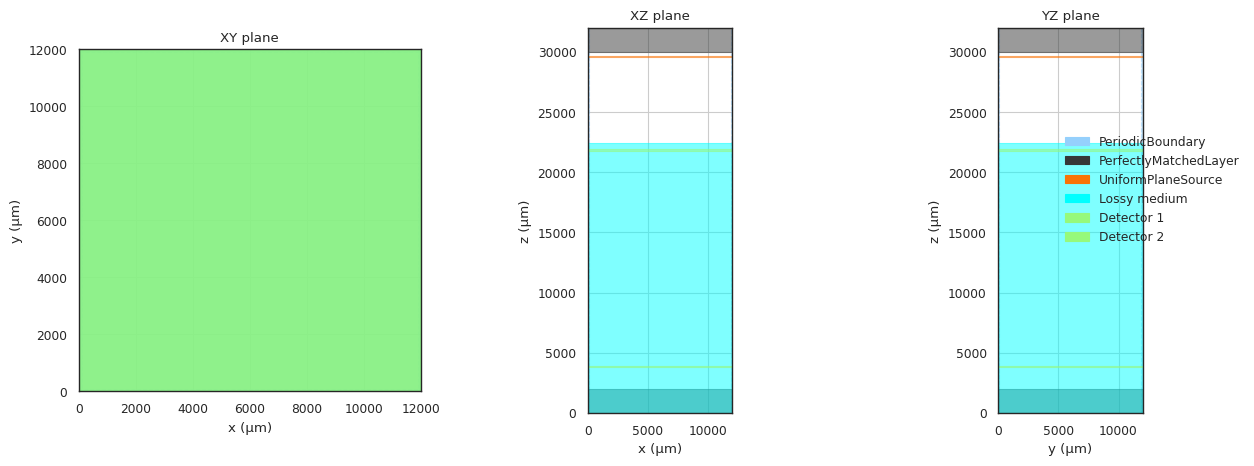

In [ ]:
_ = fdtdx.plot_setup(
    config=config,
    objects=objects,
)

We make a function that will hold the simulation, in order to JIT compile it.

In [ ]:
def sim_fn(
    params: fdtdx.ParameterContainer,
    arrays: fdtdx.ArrayContainer,
    key: jax.Array,
):
    arrays, new_objects, info = fdtdx.apply_params(arrays, objects, params, key)

    final_state = fdtdx.run_fdtd(
        arrays=arrays,
        objects=new_objects,
        config=config,
        key=key,
    )
    _, arrays = final_state

    new_info = {
        **info,
    }
    return arrays, new_info

Finally, we compile the previously defined function, and execute it.

In [14]:
compile_start_time = time.time()
jit_task_id = exp_logger.progress.add_task("JIT", total=None)
jitted_loss = jax.jit(sim_fn, donate_argnames=["arrays"]).lower(params, arrays, key).compile()
compile_delta_time = time.time() - compile_start_time
exp_logger.progress.update(jit_task_id, total=1, completed=1, refresh=True)

run_start_time = time.time()
key, subkey = jax.random.split(key)
arrays, info = jitted_loss(params, arrays, subkey)

runtime_delta = time.time() - run_start_time
info["runtime"] = runtime_delta
info["compile time"] = compile_delta_time

logger.info(f"{compile_delta_time=}")
logger.info(f"{runtime_delta=}")

exp_logger.log_detectors(iter_idx=0, objects=objects, detector_states=arrays.detector_states)

24.07.2025 09:38:34.603 | /tmp/ipykernel_3300530/1976291941.py:15 - compile_delta_time=5.723766565322876

24.07.2025 09:38:34.604 | /tmp/ipykernel_3300530/1976291941.py:16 - runtime_delta=19.612833976745605

After we execute the simulation, we obtain `arrays`, which is an
`ArrayContainer` object. Within this object, we have the attribute
`detector_states`, which is a dictionary holding all the data recorded by every
detector. We select the detector we specified before by using the name we gave
it as the key, and within this value, we have another dictionary, from which
we retrieve the data we seek by specifying `"poynting_flux"`.

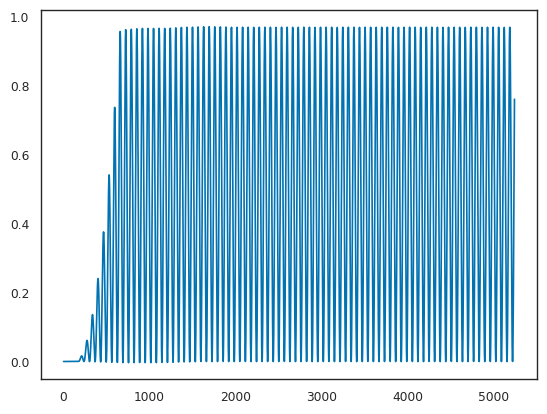

In [ ]:
plt.plot(arrays.detector_states["Detector 1"]["poynting_flux"])
plt.show()

We see that we need to wait for a short while before the system reaches a
stationary state. In the following, we shall take a look at an analytical
expression for the power flux which assumes such a state. Therefore, in order to
properly compare what FDTDX calculated to the analytical result, we need to take
the time average of the power flux at a time step where it is clear we are past
the transitory phase, which can be seen when the amplitude of the power flux
varies no longer. In our case, seeing the previous plot, we can take, for
example, time step 3000.

The frequency at which the power flux varies is double that of the field. Thus,
the period is halved, and we should calculate the time average over any integer
multiple of `period_steps / 2`.

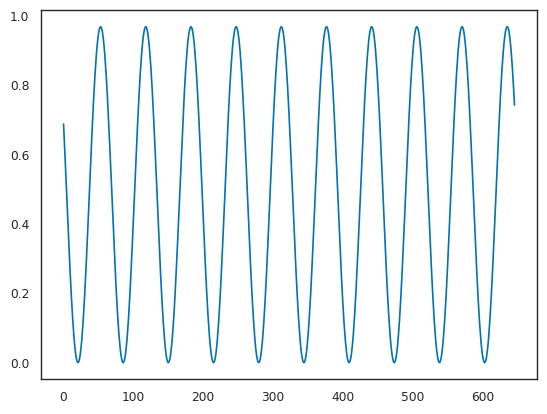

In [ ]:
exact_period_steps = period / config.time_step_duration
plt.plot(arrays.detector_states["Detector 1"]["poynting_flux"][3000:3000 + round(10 * exact_period_steps / 2)])
plt.show()

In [ ]:
power_flux_time_average_1 = jnp.mean(arrays.detector_states["Detector 1"]["poynting_flux"][3000:3000 + round(10 * exact_period_steps / 2)])
power_flux_time_average_2 = jnp.mean(arrays.detector_states["Detector 2"]["poynting_flux"][3000:3000 + round(10 * exact_period_steps / 2)])

We now compare this with the analytical result, which we will now derive.
We start from Maxwell's curl equations, assuming $\mathbf{J}_f = \sigma \mathbf{E}$

$$
\begin{aligned}
\nabla \times \mathbf{E} &= -\mu\,\frac{\partial\mathbf{H}}{\partial t}, \quad\text{(7a)}\\[2pt]
\nabla \times \mathbf{H} &= \sigma\,\mathbf{E}+\varepsilon\,\frac{\partial\mathbf{E}}{\partial t}. \quad\text{(7b)}
\end{aligned}
$$

Again, we assume a sinusoidal steady state (implicitly stepping into the
frequency domain), and we use an analytical representation (phasors, so complex
exponentials), as such time derivatives are swapped for $\mathrm{i}\omega$;

$$
\begin{aligned}
\nabla\times\tilde{\mathbf E} &= -\mathrm{i}\omega\mu\,\tilde{\mathbf H}, \quad\text{(8a)}\\[2pt]
\nabla\times\tilde{\mathbf H} &= \left(\sigma + \mathrm{i}\omega\varepsilon\right)\tilde{\mathbf E}. \quad\text{(8b)}
\end{aligned}
$$

But, we also assume a uniform plane wave, travelling in the $\hat{\mathbf{k}}$
direction, where $\hat{\mathbf{k}} = \mathbf{k}/|\mathbf{k}|$ and $\mathbf{k}$
is the wave vector. This means that the spatial dependence for both $\tilde{\mathbf{E}}$
and $\tilde{\mathbf{H}}$ is
$\mathrm{e}^{-\gamma\,\hat{\mathbf{k}}\cdot\mathbf{r}}$ with
$\gamma$ the propagation constant, equal to both fields as they are coupled to
each other through eqs. (8a) and (8b). In that case the curl can be replaced by the
vector identity

$$
\nabla\times\tilde{\mathbf E}= -\gamma\,\hat{\mathbf k}\times\tilde{\mathbf E}. \quad\text{(9)}
$$

If we insert this into (8a), we get:

$$
-\gamma\,\hat{\mathbf k}\times\tilde{\mathbf E} = -\mathrm{i}\omega\mu\,\tilde{\mathbf H}
\;\;\Longrightarrow\;\; \tilde{\mathbf H} = \frac{\gamma}{\mathrm{i}\omega\mu}\,\hat{\mathbf k}\times\tilde{\mathbf E}. \quad\text{(10)}
$$

A second substitution using (8b) gives

$$
-\gamma\,\hat{\mathbf k}\times\tilde{\mathbf H} = \left(\sigma + \mathrm{i}\omega\varepsilon\right)\tilde{\mathbf E}
\;\;\Longrightarrow\;\; \tilde{\mathbf E} = -\frac{\gamma}{\left(\sigma +
\mathrm{i}\omega\varepsilon\right)}\,\hat{\mathbf k}\times\tilde{\mathbf H}.
\quad\text{(11)}
$$

Multiplying the last expression by $\hat{\mathbf k}\times$, gives

$$
\hat{\mathbf{k}} \times \tilde{\mathbf E} = -\frac{\gamma}{\left(\sigma + \mathrm{i}\omega\varepsilon\right)}\,\hat{\mathbf k}\times\left(\hat{\mathbf k}\times\tilde{\mathbf H}\right).
\quad\text{(12)}
$$

and using the identity $\mathbf {a} \times (\mathbf{b} \times \mathbf{c})=\mathbf{b}(\mathbf{a} \cdot \mathbf{c})-\mathbf{c}(\mathbf{a} \cdot \mathbf{b})$ and the fact that $\hat{\mathbf{k}}$ is perpendicular to both $\mathbf{E}$ and $\mathbf{H}$, we get that

$$
\hat{\mathbf{k}} \times \tilde{\mathbf E} = \frac{\gamma}{\left(\sigma + \mathrm{i}\omega\varepsilon\right)}\,\tilde{\mathbf H}.
\quad\text{(13)}
$$

Comparing this to (10), we get that

$$
\frac{\gamma}{\sigma + \mathrm{i}\omega\varepsilon} = \frac{\mathrm{i}\omega\mu}{\gamma}. \quad\text{(14)}
$$

so we finally get $\gamma^2 = -\omega^{2}\mu\varepsilon + \mathrm{i}\omega\mu\sigma$. Choosing the principal square root, this yields

$$
\displaystyle \gamma = \alpha + \mathrm{i}\beta= \sqrt{\mathrm{i}\omega\mu\left(\sigma + \mathrm{i}\omega\varepsilon\right)}.
\quad\text{(15)}
$$

If we plug this into (4) and (5), and we apply the definition of wave impedance
(equal to the intrinsic impedance of the medium if considering TEM waves, which is our case)
$\eta \equiv \tilde{\mathbf{E}}_T/\tilde{\mathbf{H}}_T$, where the $T$ subindex
represents that we take the *transversal* components of the fields with respect
to the direction of propagation, we get that $\eta$ in this case is equal to

$$
\displaystyle \eta\;=\;\sqrt{\frac{\mathrm{i}\omega\mu}{\sigma + \mathrm{i}\omega\varepsilon}}.
\quad\text{(16)}
$$

Because $\sigma \neq 0$, $\eta$ is **complex**, giving a non-zero phase difference
between $\mathbf{E}$ and $\mathbf{H}$; these two fields no longer oscillate
perfectly synchronized in a lossy medium, unlike a lossless one.

Knowing all this, we compute the Poynting vector, which represents the power
flux per unit area carried by the fields. This vector is defined as
$\mathbf{S} \equiv \mathbf{E} \times \mathbf{H}$. Starting with the **phasor**
fields we obtained, assuming that $\hat{\mathbf{k}} = \hat{z}$, and that the
electric field is linearly polarized along the X axis, we get the following,

$$
\tilde{\mathbf E}(z) = E_0\mathrm e^{-\gamma z}\hat{\mathbf x},\qquad
\tilde{\mathbf H}(z) = \frac{E_0}{\eta}\mathrm e^{-\gamma z}\hat{\mathbf y},
\quad\text{(17)}
$$

and we go from the phasor or analytic representation to the real fields taking into account the
usual implicit phasor time dependence $\mathrm e^{\mathrm i\omega t}$:

$$
\mathbf E(z,t) = E_0\,e^{-\alpha z}\cos\!\bigl(\omega t-\beta z\bigr)\,\hat{\mathbf x},\\[2pt]
\mathbf H(z,t) = \frac{E_0}{|\eta|}\,e^{-\alpha z} \cos\!\bigl(\omega t-\beta z-\theta\bigr)\,\hat{\mathbf y}, \\[2pt]
\eta = |\eta|\mathrm e^{\mathrm i\theta}.
\quad\text{(18)}
$$

With these fields, we compute the Poynting vector,

$$
\mathbf S(z,t)=\mathbf E(z,t)\times\mathbf H(z,t)
= \hat{\mathbf z}\, \frac{E_0^{2}}{|\eta|}\, e^{-2\alpha z}\, \cos(\omega t-\beta z)\, \cos(\omega t-\beta z-\theta).
\quad\text{(19)}
$$

Using the identity $2\cos A\cos B=\cos(A-B)+\cos(A+B)$, we finally get:

$$
\boxed{\; \mathbf S(z,t)=\hat{\mathbf z}\; \frac{E_0^{2}}{2|\eta|}\, e^{-2\alpha z}\, \Bigl[\cos\theta +\cos\!\bigl(2\omega t-2\beta z-\theta\bigr) \Bigr]\!. }
\quad\text{(20)}
$$

- **First term**
$\displaystyle \frac{E_0^{2}}{2|\eta|}\cos\theta\,e^{-2\alpha z}$ is the steady
(time-average) power density.
- **Second term** is a purely oscillatory contribution that swings the power
flow above and below the average value.

The argument of the cosine is $2\omega t - 2\beta z - \theta$;
the time dependence is therefore **cosinusoidal at angular frequency $2\omega$**, i.e.
$f_{\mathbf S} = \frac{2\omega}{2\pi} = 2f_{\text{wave}}$.

So the instantaneous power density contains a **DC component** (the average
power) **plus an AC component at twice the original wave frequency**.
Over one period $T = 2\pi/\omega$ the cosine averages to zero.

Note that (20) was derived taking into account that the lossy medium permeates
all of space. This clashes with the simulation setup we considered, which rather
looks to emulate a half-infinite slab of lossy medium with the other half-infinite
portion of space occupied by vacuum. However, since we have normal incidence (no
total internal reflection; modes are propagating and not evanescent),
Maxwell equations are locally the same in the same medium, whether or not
it is a half-infinite slab or a medium occupying all space, and since there
isn't another change of boundary conditions further within the lossy medium,
we can assume there is only one exponentially attenuating wave, just as in
the analytical solution we derived.

There is one remaining problem; we specified the initial amplitude of the plane wave
at 1 V/m, however that is not the same $E_0$ that is in (20). In the simulation,
the analytical $E_0$ corresponds to the amplitude of the field *right at the
beginning of the lossy medium, at the interface between media*, which we haven't
actually measured. What we *can* use is the **ratio between both power flux
detectors** (that is why we placed two detectors), which, analytically, means
that we calculate $\langle\mathbf{S}(z_2)\rangle/\langle\mathbf{S}(z_1)\rangle$.
Computing this ratio using (20) does away with most factors found in that
result, and it's not even necessary to multiply each Poynting flux at either value
of $z$ by the area of the respective detectors, as it is the same in both of
them (remember that this would have been necessary as in the simulation we
measure power flux over the total detector area, not power flux per unit area as
$\mathbf S$ alone represents). This ratio is thus equal to $\mathrm
e^{-2\alpha(z_2 - z_1)}$. $\alpha$ is

$$
\alpha = \sqrt{\frac{\omega\mu\varepsilon}{2}}\left[\sqrt{1 + \left(\frac{\sigma}{\omega\varepsilon}\right)^2} - 1\right]^{1/2}
$$

We define a function computing this ratio,

In [ ]:
def irradiance_ratio(
    freq: float,
    z: float,
    sigma: float,
    eps_r: float = 1.0,
    mu_r: float = 1.0,
) -> jax.Array:
    """
    Ratio of irradiance between two parallel planes separated by a distance `z`,
    both perpendicular to the direction of propagation of a plane wave in a
    lossy medium defined by a user-specified real permittivity, real
    permeability, and real conductivity.

    Parameters
    ----------
    freq : float
        Frequency of plane wave (Hz).
    z : float
        Distance between planes (m).
    sigma : float
        Conductivity as used in the vector form of Ohm's law. (S/m).
    eps_r : float, optional
        Relative permittivity ε_r (default 1.0).
    mu_r : float, optional
        Relative permeability μ_r (default 1.0).

    Returns
    -------
    jax.Array
        Irradiance ratio.
    """
    omega = 2.0 * jnp.pi * freq
    eps = fdtdx.constants.eps0 * eps_r
    mu = fdtdx.constants.mu0 * mu_r
    ratio = sigma / (omega * eps)
    root = jnp.sqrt(1.0 + ratio**2)
    alpha = jnp.sqrt((omega * mu * eps) / 2.0) * jnp.sqrt(root - 1.0)
    return jnp.exp(-2 * alpha * z)

So analytically, this is finally

In [ ]:
irradiance_ratio(freq=frequency, z=n_cells_z * cell_size, sigma=sigma, eps_r=eps_r, mu_r=mu_r)

Array(0.9999575, dtype=float32, weak_type=True)

Which we now compare with the simulation result,

In [ ]:
power_flux_time_average_2 / power_flux_time_average_1

Array(0.9383129, dtype=float32)